## Homework Assignment 3: Exploratory Data Analysis
### Dua Batool 
### db07098@st.habib.edu.pk

## Part 1

In [61]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime 
import seaborn as sns

In [62]:
data: pd.DataFrame = pd.read_csv('loan_small.csv')

### Counting the columns with missing values

In [63]:
# Sorting the data with the highest missing values first
data.isnull().sum().sort_values(ascending=False).head()

mths_since_last_record    979
mths_since_last_delinq    774
emp_title                  51
emp_length                 17
last_pymnt_d                1
dtype: int64

### Removing non-numerical strings such as "months" from a column and only keeping numeric values

In [64]:
def remove_them(column):
    data[column] = data[column].astype(str).str.strip().replace('[^.0-9]+', '', regex=True)  # replacing anything except numbers and period with ''
    return list(set(data[column]))

column = 'term'
value_list = remove_them(column) 
data[column].head()

0    36
1    60
2    36
3    36
4    60
Name: term, dtype: object

### Removing '<', '>' or '+' from emp_length

In [65]:
column = 'emp_length'
data[column] = data[column].replace({np.nan: '0', 'n/a': '0'})    # Replacing NaN values with 0 since we need to make this column numerical
value_list = remove_them(column) # using the same function to remove  <,>,+ and years from the column
data[column].head()

0    10
1     1
2    10
3    10
4     1
Name: emp_length, dtype: object

### Converting loan_status to “good” or “bad” 

In [66]:
column = 'loan_status'
value_list = list((set(data[column])))
print(f'The values of column {column} are:')
print(value_list)

# Setting 'Fully Paid' & 'Current' to 'Good' while 'Late', 'Charged Off' and 'Default' to 'Bad'
# Good means a value of 1 and Bad means a value of 0
def good_bad(loanStatus: str):
    if loanStatus.lower() in ['fully paid', 'current']: return '1'
    else: return '0'

data[column] = data[column].apply(good_bad)
value_list = list((set(data[column])))
print(f'After making this attribute binary, the values are:')
print(value_list)
data[column].head()

The values of column loan_status are:
['Late (31-120 days)', 'Fully Paid', 'Current', 'Charged Off', 'Default']
After making this attribute binary, the values are:
['1', '0']


0    1
1    0
2    1
3    1
4    1
Name: loan_status, dtype: object

### Helper functions

In [67]:
# Helper functions for imputation
def fill_custom(column, custom_str):
    data[column] = data[column].fillna(custom_str)   # filling the NaN values of the attribute with a custom string

def fill_mean(column):
    data[column] = data[column].astype(float).fillna(data[column].mean())   # filling the NaN values of the attribute with the mean of the attribute
    
# Helper function to check the percentage of missing values of a column
def check_missing(attribute: str):
    attribute_data = data[attribute]  # Get the data of the attribute
    percent_missing = attribute_data.isnull().sum() * 100 / len(attribute_data)  # Calculate the percent of missing values
    return percent_missing  # Return the percent of missing values

### Get the columns which have missing values

In [68]:
null_columns: pd.Series = data.columns[data.isnull().any()]
null_columns.to_list() 

['emp_title',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'last_pymnt_d']

### Imputation for mths_since_last_delinq column
The proportion of missing data in the column is checked first; if it is higher than 90, the column is dropped; otherwise, imputation is used. This characteristic indicates how many months have passed since the most recent infraction. This attribute's absent value most likely indicates that the borrower has no delinquency at all. The missing values will be changed to a high number (the maximum value) since it may be necessary to maintain track of individuals who recently engaged in delinquency (a low value of this characteristic). 

In [69]:
column = 'mths_since_last_delinq'
percentage_missing = round(check_missing(column), 2)  # using helper function 
print(f"{column} has {percentage_missing}% missing values.." )  
if (percentage_missing > 90):  
    data.drop([attribute], axis=1, inplace=True)  
else:
    maxValue = data[data[column].notna()][column].astype(int).max() + 2
    fill_nan_with_custom(column, maxValue)  # Fill the NaN values with the max value of the attribute
    value_list = remove_them(column)
    print(
        f"The values of attribute: {column} range from {min(value_list)} - {max(value_list)}"
    )


mths_since_last_delinq has 77.48% missing values..
The values of attribute: mths_since_last_delinq range from 10.0 - 9.0


### Imputation for mths_since_last_record attribute
The proportion of missing data in the column is checked first; if it is higher than 90, the column is dropped; otherwise, imputation is used. Around 98% of the data for this characteristic is missing, because of which I have removed this column from the data frame.

In [70]:
column = 'mths_since_last_record'
percentage_missing = round(check_missing(column), 2)
print(f"{column} has {percentage_missing}% missing values.." )
if (percentage_missing > 90):
    print("Dropping the column because of high missing values")
    data.drop([column], axis = 1, inplace=True)

mths_since_last_record has 98.0% missing values..
Dropping the column because of high missing values


### Imputation attribute for last_pymnt_d
Replacing the missing value with the issued date.

In [71]:
column = 'last_pymnt_d'
percentage_missing = round(check_missing(column), 2)
print(f"{column} has {percentage_missing}% missing values..")

issuedDate_attribute = 'issue_d'
rows_with_nan = data[data[column].isnull()].index.tolist()
for row in rows_with_nan:  
    issued_data = data[issuedDate_attribute].iloc[row]
    data.at[row, column] = issued_data  

print( 'Rows affected by imputation -->')  # Print the rows affected by imputation
data[column][data[column].index.isin(rows_with_nan)].to_frame()

last_pymnt_d has 0.1% missing values..
Rows affected by imputation -->


,last_pymnt_d
26,Dec-11


### Imputation for emp_title
Replacing the missing values with 'No Title.

In [72]:
column = 'emp_title'
rows_with_nan = data[data[column].isnull()].index.tolist()
percentage_missing = round(check_missing(column), 2)
print(f"{column} has {percentage_missing}% missing values.")
fill_custom(column, 'No Title')
print(rows_with_nan)

emp_title has 5.11% missing values.
[0, 2, 8, 30, 42, 61, 110, 168, 186, 199, 243, 267, 270, 275, 288, 300, 323, 394, 422, 437, 439, 473, 485, 491, 534, 553, 555, 562, 569, 578, 604, 657, 668, 680, 712, 713, 714, 752, 776, 852, 860, 863, 866, 875, 902, 904, 933, 961, 975, 984, 985]


### Cleaning/formatting the date columns

In [73]:
# converting mm-yy to yy-mm-dd
def fixDate(date: str):
    year = date.split("-")[0]
    if (len(year) == 1): date = "0" + date
    date = datetime.strptime(date, '%b-%y')
    return date

date_cols = ['earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'issue_d']
for date_col in date_cols: 
    data[date_col] = data[date_col].apply(fixDate) # Applying the helper function 

### Cleaning all columns
Cycling through all of the columns, and removing any column that has all values that are the same, or has more zeros than 90% of the time.

In [74]:
cols_to_drop = set()
for col in data.columns:  
    col_data = data[col].astype(str)
    zero_occurences = len(col_data[col_data.isin(['0', '0.0'])])
    unique_values = len(set(col_data)) 

    if unique_values == 1:     # if all values are the same
        cols_to_drop.add(col)  # add column to drop list

    if (zero_occurences / len(data)) * 100 > 90:   # if more than 90% of values are 0
        cols_to_drop.add(col)  # add column to drop list

cols_to_drop.remove('issue_d')
data.drop(list(cols_to_drop), axis=1, inplace=True)
print("Columns dropped: ", cols_to_drop)

Columns dropped:  {'out_prncp_inv', 'delinq_2yrs', 'pymnt_plan', 'application_type', 'total_rec_late_fee', 'out_prncp', 'initial_list_status', 'pub_rec'}


### Dropping ID column
Since we already have 'member_id' column, we do not need the id column

In [75]:
column = 'id' 
data.drop(column, axis=1, inplace=True) 

### Making a cleaned CSV File

In [76]:
data.to_csv('loan_small_cleaned.csv', index=False)

## Part 2

## - Descriptions

In [77]:
data: pd.DataFrame = pd.read_csv('loan_small_cleaned.csv')
columns = list(data.columns)

### Helper functions

In [78]:
# returns 25th percentile of the attribute
def percentile_25(x: pd.DataFrame):
    return x.quantile(0.25)

# returns 75th percentile of the attribute
def percentile_75(x: pd.DataFrame):
    return x.quantile(0.75)

# returns description dataframe of an attribute
def description(col_name: int, type: type = int):
    column: pd.Series = data[col_name]
    if type == str: return column.astype(type).describe()
    stats = ['count', 'mean', 'std', 'min', percentile_25, 'median', percentile_75, 'max', 'skew', 'kurtosis', 'sem']
    return column.astype(type).agg(stats)

# returns the concatenated descriptions of a list of attributes
def descriptions(columns: list, type: type = int):
    dfs = [description(col, type=type) for col in columns]
    return pd.concat(dfs, axis=1)

### Descriptions for loan_amnt, funded_amnt, and, funded_amnt_inv, int_rate, and, installment

In [79]:
cols = [ 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length' ]
descriptions(cols)  

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,12704.354354,12197.797798,12137.145145,12.374374,366.496496,5.274274
std,7463.253235,6804.931895,6743.301975,3.971086,200.505138,3.390256
min,1000.000000,1000.000000,1000.000000,6.000000,33.000000,0.000000
percentile_25,7050.000000,7000.000000,7000.000000,9.000000,223.000000,2.000000
median,11500.000000,11000.000000,10800.000000,12.000000,337.000000,5.000000
percentile_75,16050.000000,16000.000000,15946.500000,15.000000,469.000000,9.000000
max,35000.000000,35000.000000,35000.000000,23.000000,1243.000000,10.000000
skew,0.972309,0.898703,0.894327,0.261912,1.059812,0.187392
kurtosis,0.608070,0.617172,0.610167,-0.683246,1.468724,-1.415039


The description above shows that the first three attributes range from 1000 to 35000 and they are moderately skewed.

Loan amount: <br>
The mean is 12704 and the standard deviation of 7463 shows us that the average value of this attribute is 7463 away from the mean. The median is 11500. This means that on average every member took a loan of around 11000-13000.  

Funded amount: <br>
The mean is 12197 and the standard deviation is 6804. The median is 11000. This means that on average every value of this attribute is around 11000-12000. 

Funded amount investment: <br>
The mean is 12137 and the standard deviation is 6743. The median is 10800. This means that on average this attribute will have a value of around 11000-12000. 

interest rate: <br>
The interest rate ranges from 6 to 23. The mean is 12.3 and the median is 12. Average interest rate should be between 12-13.

installment: <br>
The installment ranges from 33 to 1243. The mean is 366 and the median is 377. 

employement length: <br>
The employement length ranges from 0 to 10. The mean is 5.2 and the median is 5. This means everyone approximately has 5 years of employement. 

### Descriptions for term, grade, and, sub_grade, home_ownership, and, verification status;

In [80]:
cols = [ 'term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'loan_status' ]
descriptions( cols, type=str)  # str because the attributes are categorical

,term,grade,sub_grade,home_ownership,verification_status,purpose,loan_status
count,999,999,999,999,999,999,999
unique,2,7,34,3,3,13,2
top,36,B,B3,RENT,Verified,debt_consolidation,1
freq,725,354,84,596,366,527,820


term:  <br>
It takes only two values; 36 and 60. The most frequent value is 36 months and 725/999 people have this term. 
<br><br>
grade: <br>
There are 7 possible grades. The most frequent value is B and 354/999 have this grade.
<br><br>
sub_grade: <br>
There are 34 possible sub grades. The most frequent value is B3 and 84/999 people have this sub_grade.
<br><br>
home_ownership: <br>
There are 3 possible homeownerships. The most frequent value is RENT and 596 / 999 people have home ownership on rent..
<br><br>
verification_statis: <br>
There are 3 possible statuses. The most frequent value is Verified and 366 / 999 people have this status..
<br><br>
purpose: <br>
There are 13 possible purposes. The most frequent value is debt_consolidation and 527 / 999 people have this purpose..
<br><br>
loan_status: <br>
There are 2 possible statuses. The most frequent value is Good and 820 / 999 people have good loan status.


### Descriptions for 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', and,  'total_rec_int'

In [81]:
cols = ['annual_inc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int']
descriptions(cols) 

,annual_inc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int
count,999.000000,999.000000,999.000000,999.000000,999.000000
mean,62118.787788,13218.478478,13123.107107,10395.425425,2703.153153
std,31899.140137,8515.592262,8384.003855,6727.557033,2757.603611
min,12000.000000,0.000000,0.000000,0.000000,0.000000
percentile_25,40000.000000,6903.000000,6894.000000,5109.500000,960.000000
median,55000.000000,11599.000000,11593.000000,9600.000000,1807.000000
percentile_75,75500.000000,17559.000000,17404.500000,14000.000000,3279.500000
max,276000.000000,45755.000000,44519.000000,35000.000000,19834.000000
skew,1.790215,1.057222,1.034046,0.998537,2.471013
kurtosis,5.739693,0.999745,0.917993,0.987211,8.447695


Annual Income:<br>
The mean is 62118 and the median is 55000
<br><br>
Total payment:<br>
The mean is 13218 and the median is 11599
<br><br>
Total payment inv:<br>
The mean is 13123 and the median is 11593
<br><br>
Total recieved principal:<br>
The mean is 10395 and the median is 9600
<br><br>
Total recieved interest:<br>
The mean is 2703 and the median is 1807
<br><br>

### Grouping data with good loan status and data with bad status

In [82]:
good_filter = data['loan_status'] == 1
bad_filter = data['loan_status'] == 0

good_status_data = data[good_filter]  # Select only good loans
bad_status_data = data[bad_filter]  # Select only bad loans

### Helper functions to get a data frame containing counts of good and bad loans

In [83]:
# get the ratio of the counts of the good loan wrt to the count of bad loans
def get_ratio_df(attribute: str) -> pd.DataFrame:
    good_status_counts = good_status_data[attribute].value_counts()
    bad_status_counts = bad_status_data[attribute].value_counts()
    ratio = good_status_counts / bad_status_counts
    return ratio

def plot_ratio_barChart(attribute, rot=0):
    ratio_df = get_ratio_df(attribute)
    ratio_df = ratio_df.sort_index()
    ratio_df.plot.bar(xlabel=attribute,
                      ylabel='ratio of good loans wrt bad loans',
                      rot=rot)

good_descriptions = good_status_data.describe()
bad_descriptions = bad_status_data.describe()

In [84]:
good_descriptions

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,...,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,recoveries,collection_recovery_fee,last_pymnt_amnt
count,8.200000e+02,820.000000,820.000000,820.000000,820.000000,820.00000,820.000000,820.000000,820.000000,820.0,...,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.0,820.0,820.000000
mean,1.291163e+06,12605.731707,12122.317073,12072.556955,41.970732,12.64922,366.780098,5.247561,63497.366561,1.0,...,14043.800000,63.652232,20.579268,14422.645413,14327.059451,11659.883573,2761.985634,0.0,0.0,3270.859390
std,2.275957e+04,7450.085987,6842.439800,6784.400822,10.381684,3.83022,204.021734,3.353919,32668.979819,0.0,...,9320.071441,23.176480,9.860062,8461.430128,8326.123120,6548.281542,2776.185012,0.0,0.0,4720.829756
min,9.431350e+05,1000.000000,1000.000000,1000.000000,36.000000,6.03000,33.940000,0.000000,12252.000000,1.0,...,0.000000,0.000000,3.000000,1017.550000,1017.550000,1000.000000,17.550000,0.0,0.0,1.830000
25%,1.290138e+06,7000.000000,7000.000000,7000.000000,36.000000,9.91000,222.280000,2.000000,40000.000000,1.0,...,7508.250000,50.000000,13.000000,8128.077253,8128.077500,7000.000000,991.875000,0.0,0.0,321.095000
50%,1.293218e+06,11000.000000,10662.500000,10575.000000,36.000000,12.42000,334.160000,5.000000,56000.000000,1.0,...,12394.000000,67.250000,19.000000,12597.988290,12552.895000,10000.000000,1847.770000,0.0,0.0,761.350000
75%,1.298976e+06,16000.000000,15806.250000,15637.500000,36.000000,15.27000,467.820000,9.000000,80000.000000,1.0,...,18330.250000,81.300000,26.000000,18643.361730,18391.270000,15000.000000,3418.865000,0.0,0.0,4878.005000
max,1.313524e+06,35000.000000,35000.000000,35000.000000,60.000000,23.91000,1243.850000,10.000000,276000.000000,1.0,...,93718.000000,99.300000,79.000000,45755.229980,44519.610000,35000.000000,19834.120000,0.0,0.0,28412.430000


In [85]:
bad_descriptions

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,...,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,recoveries,collection_recovery_fee,last_pymnt_amnt
count,1.790000e+02,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0,...,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,1.293464e+06,13156.145251,12543.575419,12433.136500,45.385475,14.391117,367.966872,5.396648,55803.524916,0.0,...,14388.173184,70.045810,20.094972,7704.922737,7610.554581,4603.756369,2436.363296,662.325363,54.793209,435.022626
std,1.071825e+04,7527.716386,6638.187050,6562.299256,11.744567,3.804767,184.101939,3.559161,27307.524207,0.0,...,10031.207096,21.698836,10.095439,6316.984547,6156.455346,3919.507273,2662.038993,1302.804639,200.160832,811.177793
min,1.222612e+06,1000.000000,1000.000000,1000.000000,36.000000,6.620000,34.500000,0.000000,12000.000000,0.0,...,1104.000000,3.200000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.290512e+06,8000.000000,8000.000000,8000.000000,36.000000,12.065000,233.955000,2.000000,35680.000000,0.0,...,8165.000000,59.900000,13.000000,3399.980000,3248.775000,1665.100000,815.395000,11.425000,0.000000,200.000000
50%,1.294478e+06,12000.000000,12000.000000,11875.000000,36.000000,14.270000,344.200000,5.000000,50132.000000,0.0,...,11774.000000,74.900000,18.000000,6351.590000,6351.590000,3576.750000,1634.430000,299.310000,3.670000,335.450000
75%,1.299692e+06,17075.000000,16662.500000,16187.500000,60.000000,17.270000,477.440000,10.000000,70000.000000,0.0,...,18491.000000,86.450000,26.000000,10048.570000,10048.570000,6274.360000,2955.165000,742.150000,9.850000,481.990000
max,1.314167e+06,35000.000000,35000.000000,35000.000000,60.000000,23.130000,944.710000,10.000000,235000.000000,0.0,...,74351.000000,99.800000,61.000000,40669.770000,40669.770000,23024.990000,19689.100000,11349.520000,2043.180000,10000.000000


Insight: People with bad loan status seems to have a higher loan amount, dunded amount, installment, interest rate and a lower annual income than people with a good loan status. This might be because lower annual income or higher interest may have caused the loan taker to not be pay back the loan. 

## Data Analysis

## Univariate & Bivariate

### Helper function to plot a bar chart of categorical variables

In [86]:
# plot bar chart of the value counts of the attribute
def plotCountPlot(attribute: str, rotate=False):
    ax = sns.countplot(x=attribute, data=data, order=sorted(list(set(data[attribute]))))
    if rotate: ax.tick_params(axis='x', rotation=90)

# plot the bar chart of the of the attribute with respect to the loan status
def plotBarPlot(attribute: str, rotate=False):
    ax = sns.barplot(x=attribute, y='loan_status', data=data, order=sorted(list(set(data[attribute]))))
    if rotate: ax.tick_params(axis='x', rotation=90)

### Helper functions for continous variables

In [87]:
# plot histplot, violinplot, and, boxplot side by side
def plot_hist_viol_box(attribute: str) -> None: 
    _, ax = plt.subplots(ncols=3, figsize=(15, 5)) # create 3 subplots

    sns.histplot(data=data[attribute], ax=ax[0]) # histplot
    sns.violinplot(data=data[attribute], inner="quartile", ax=ax[1]) # violinplot
    sns.boxplot(data=data[attribute], orient='v', ax=ax[2]) # boxplot
    
    ax[0].set_title("Hist Plot") 
    ax[1].set_title("Vilon Plot") 
    ax[2].set_title("Box Plot") 

### Loan amount 

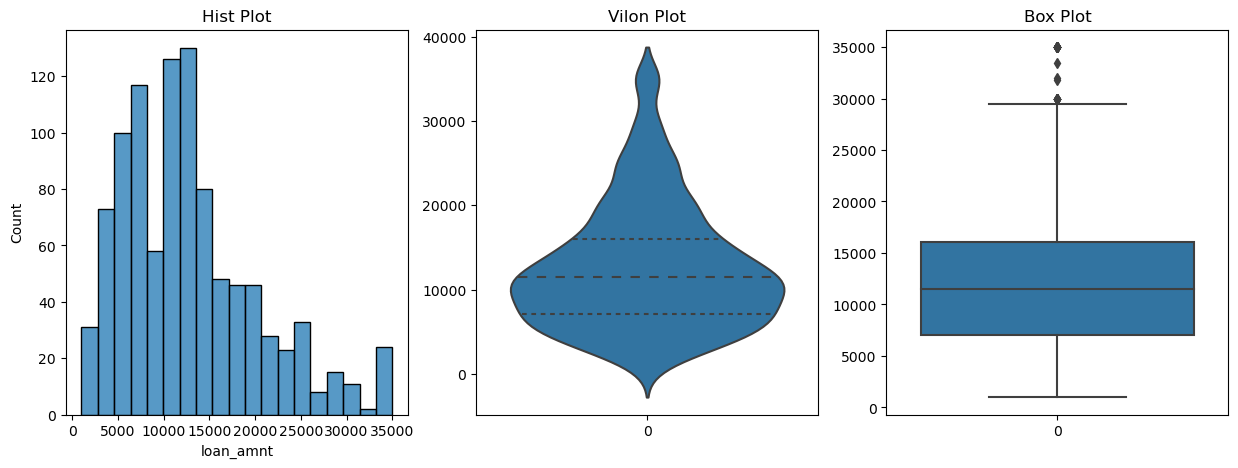

In [89]:
plot_hist_viol_box('loan_amnt') # plot histplot, violinplot, and, boxplot 

Insight: The loan amount tends to be between 8000 and 15000.

### Interest rate

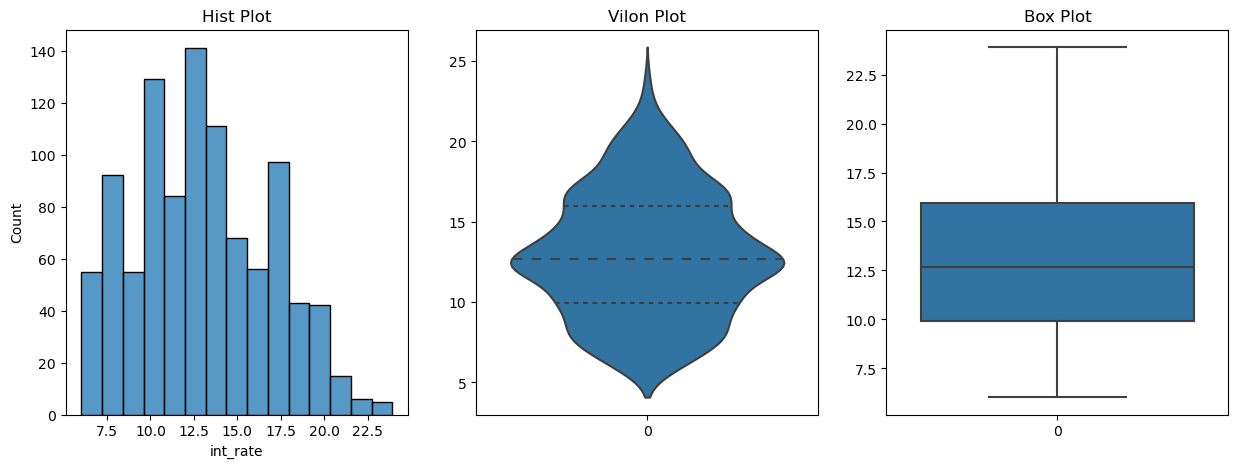

In [90]:
plot_hist_viol_box('int_rate') # plot histplot, violinplot, and, boxplot 

Insight: The interst rate tends to be between 10 and 16.

### Annual Income

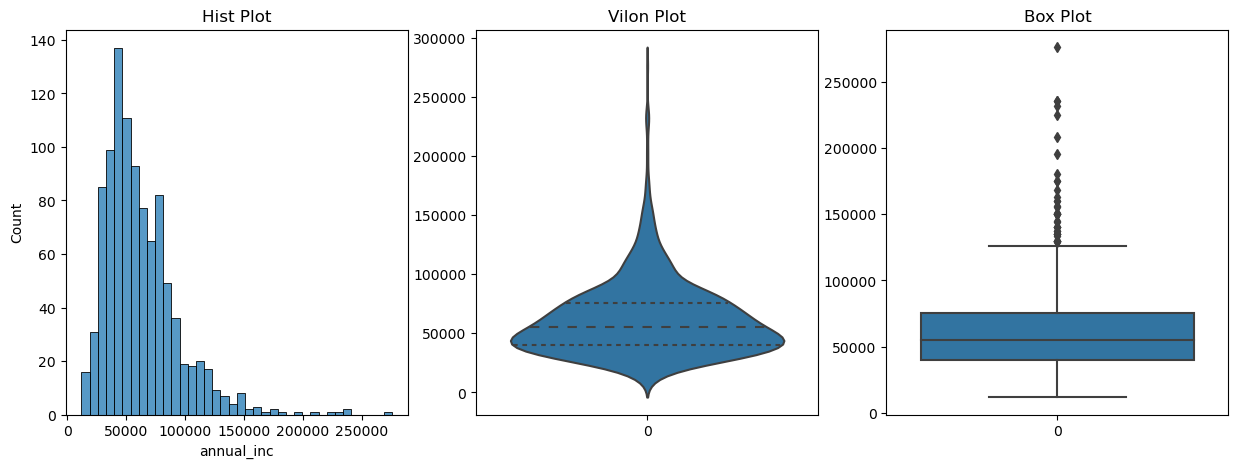

In [91]:
plot_hist_viol_box('annual_inc') # plot histplot, violinplot, and, boxplot 

Insight: The annual incomes tends to be between 40000 and 70000.

### Employment Length

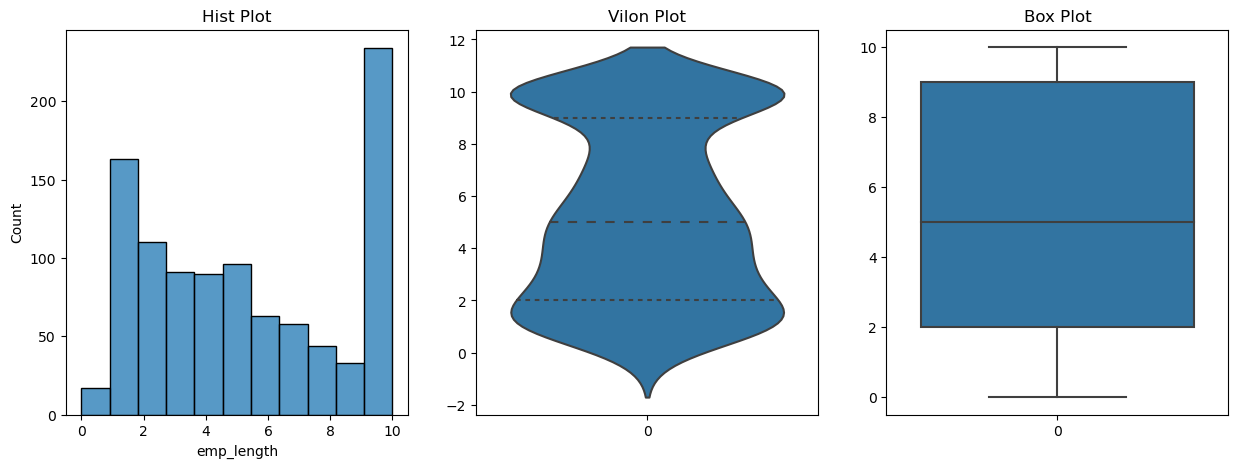

In [93]:
plot_hist_viol_box('emp_length') # plot histplot, violinplot, and, boxplot 

Insight: The data seems to be very distributed but most probably it tends to be between 2 and 9. 

### Bar charts for the attribute 'Term'

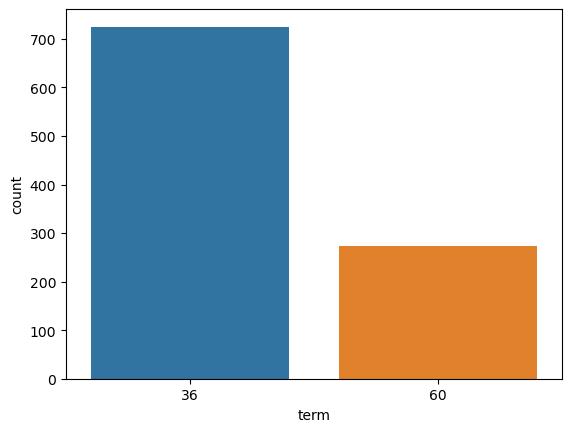

In [94]:
plotCountPlot('term') # plot bar chart of term

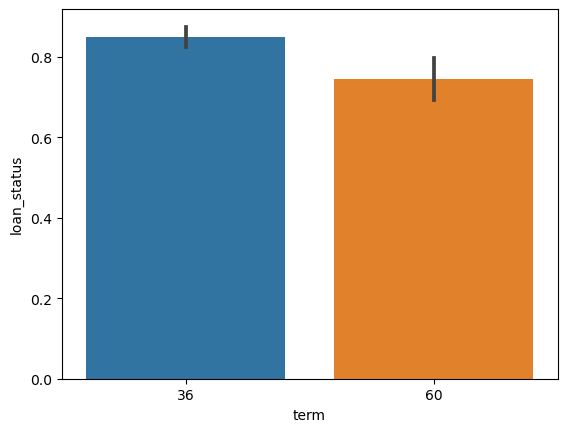

In [95]:
plotBarPlot('term') # plot bar chart of term wrt loan status

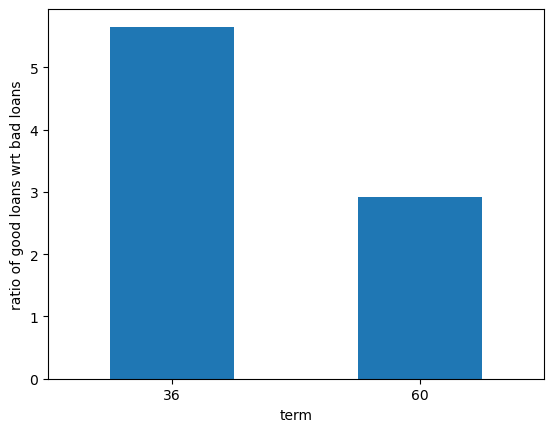

In [96]:
plot_ratio_barChart('term') # plot bar chart of term wrt ratio of good & bad loans

Insight: The count plot shows that the members with term of 36 months are much higher than the members with 60 months. The bar plot with respect to the loan status shows that members with 36 months term have a better loan status than members with 60 months term. 

### Bar charts for the attribute 'Grade'

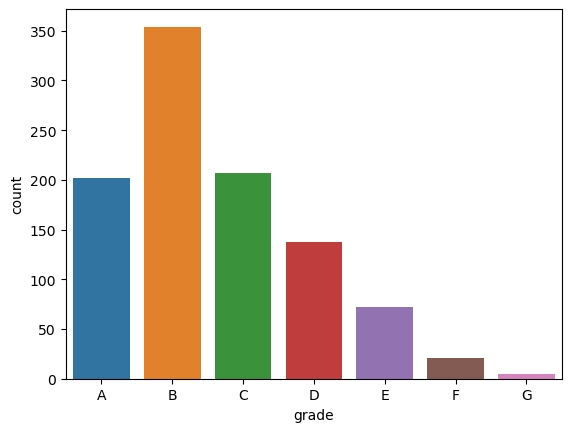

In [97]:
plotCountPlot('grade') # plot bar chart of grade

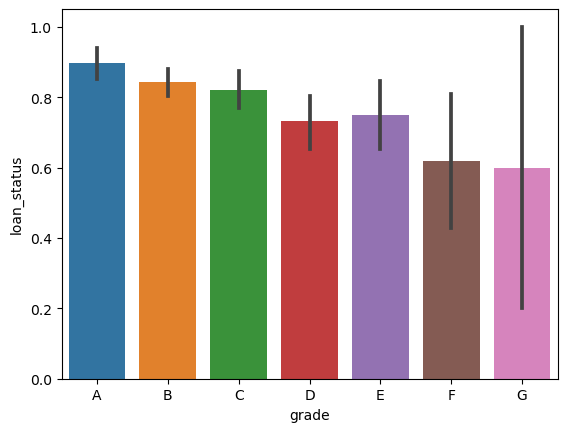

In [98]:
plotBarPlot('grade') # plot bar chart of grade wrt loan status

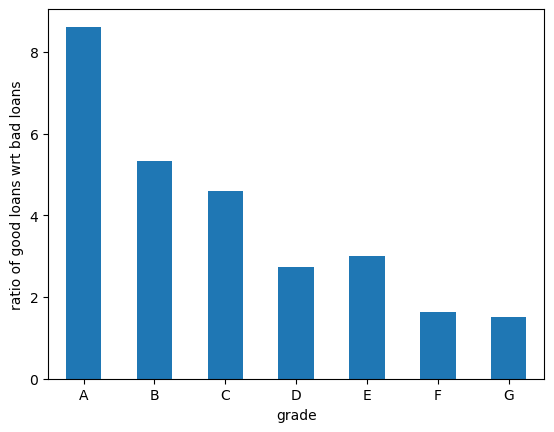

In [99]:
plot_ratio_barChart('grade') # # plot bar chart of grade wrt ratio of good & bad loans

Insight: The count plot shows that the grade B has the highest frequency and grade A, grade C comes next. The second bar plot shows us that as the grade goes A to G the loan status tends to be Bad. 

### Bar plots of the attribute 'Sub Grade'

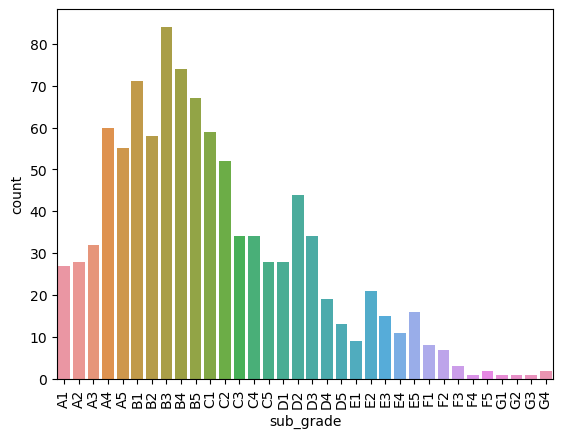

In [100]:
plotCountPlot('sub_grade', rotate=True) # plot bar chart of sub_grade

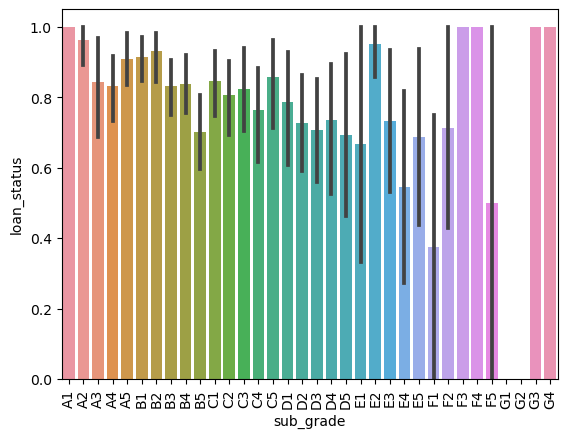

In [102]:
plotBarPlot('sub_grade', rotate=True) # plot bar chart of sub_grade wrt loan status

### Bar plots of the attribute 'Home Ownership' 

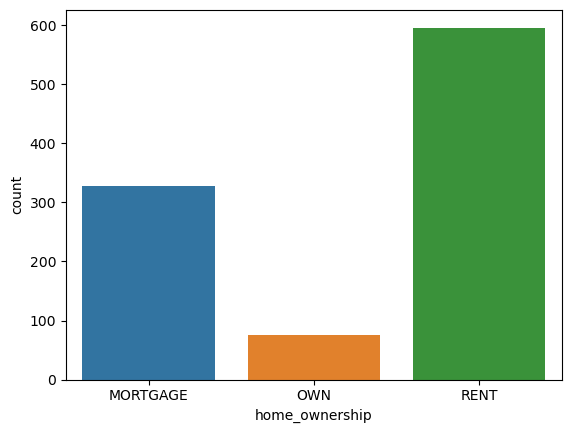

In [103]:
plotCountPlot('home_ownership') # plot bar chart of home_ownership

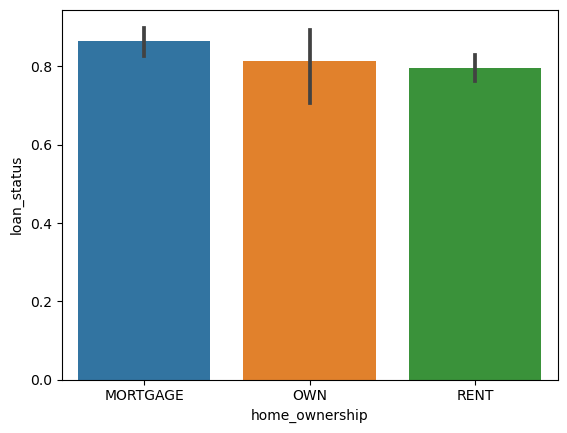

In [104]:
plotBarPlot('home_ownership') # plot bar chart of home_ownership wrt loan status

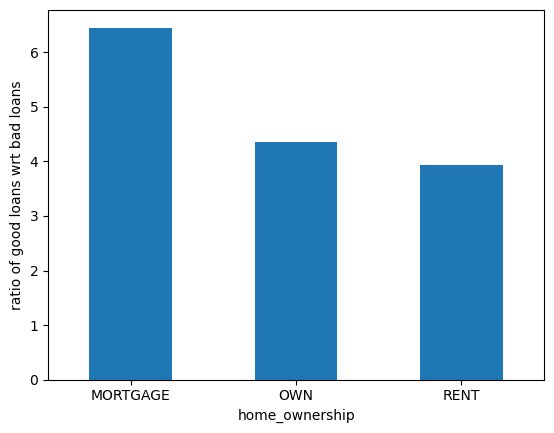

In [105]:
plot_ratio_barChart('home_ownership') # plot bar chart of home_ownership wrt ratio of good & bad loans

Insight: The count plot shows people with home ownership as rent are much higher in frequency than people own or mortgage homes. The second and third plot clearly show that people who mortgage their home have a much better chance to have a good loan status than the other people. 

### Bar plots of the attribute 'Verification Status'  

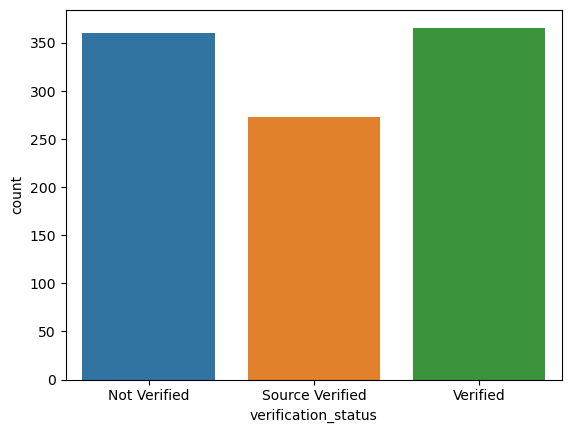

In [106]:
plotCountPlot('verification_status') # plot bar chart of verification_status

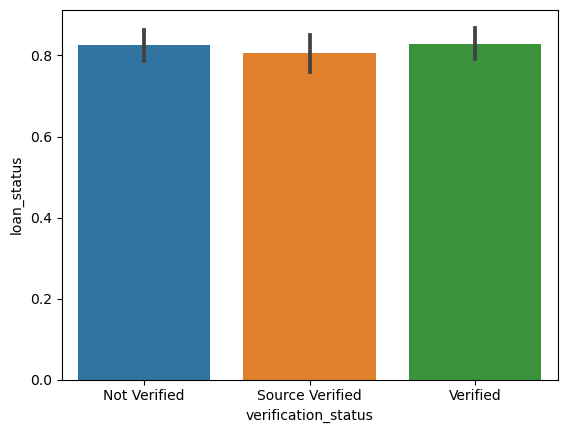

In [107]:
plotBarPlot('verification_status') # plot bar chart of verification_status wrt loan status

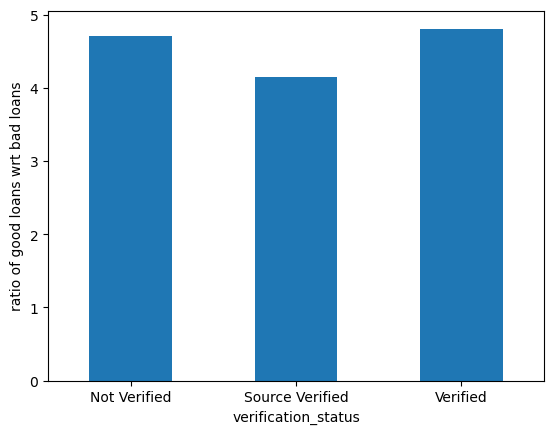

In [108]:
plot_ratio_barChart('verification_status') # plot bar chart of verification_status wrt ratio of good & bad loans

Insight: The count plot shows us that the number of verified and non verified members are almost equal while source verified comes next. The second and third plot do not provide useful insights into good and bad loan statuses.

### Bar chart for the attribute 'Loan Status'

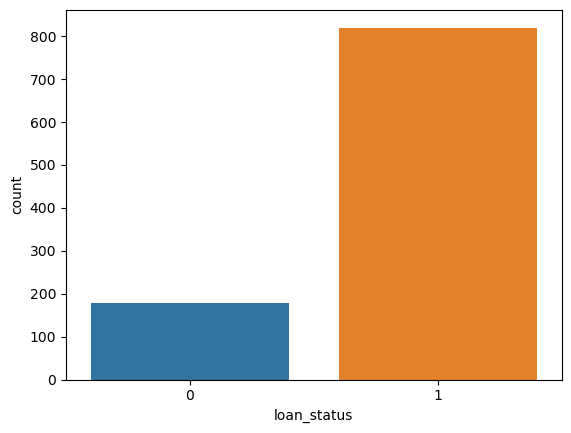

In [109]:
plotCountPlot('loan_status') # plot bar chart of loan_status

Insight: The people with a good loan status are much higher than people with a bad loan status.

### Bar charts for the attribute 'Purpose'

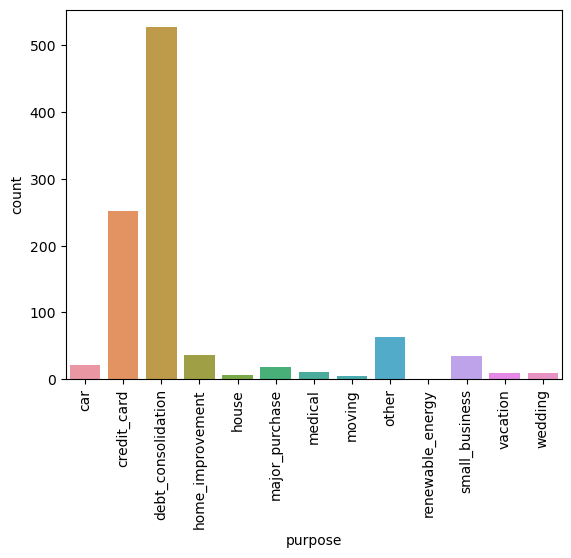

In [110]:
plotCountPlot('purpose', True) # plot bar chart of purpose

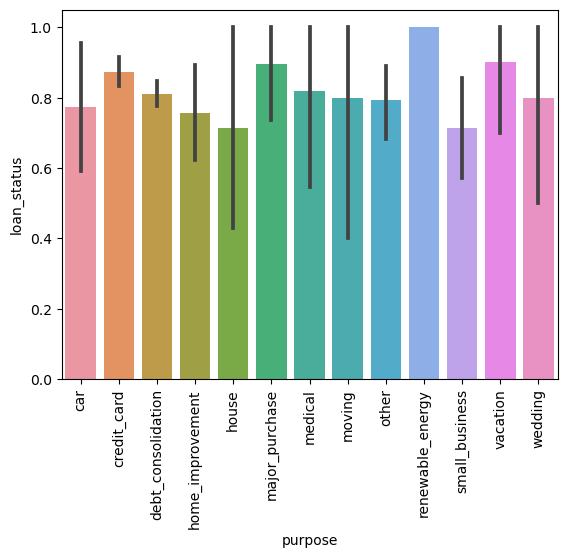

In [111]:
plotBarPlot('purpose', True) # plot bar chart of purpose wrt loan status'

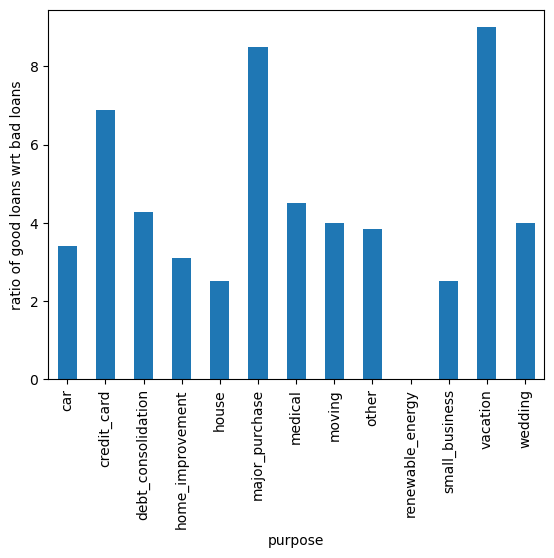

In [112]:
plot_ratio_barChart('purpose', 90) # plot bar chart of purpose wrt ratio of good & bad loans

Insight: The value counts plot shows us that the people with debt consolidation as their purpose are the highest in frequency, and the purpose of credit cards is second highest in frequency while other purpsoes are comparitively much lesser in frequency. The third plot shows us that people who went to a vaccation and did a major puchase tend to have a much better ratio of a good loan statuses with respect to bad loan statuses. However, the second plot gives a more clear insight such that people with a purpose of renewable energy have a much better to chance to have a loan status of 1.

### Helper function to plot box plot of two attributes

In [113]:
def plot_bivariate(
        attribute1: str, 
        attribute2: str,  
        plot=sns.boxplot,  
        hue=None
        ):  # hue

    plt.figure(figsize=(10, 6))  # set figure size
    plot(data=data,
         x=attribute1,
         y=attribute2,
         hue=hue
         )  # plot bivariate plot
    plt.title(attribute1 + ' vs ' + attribute2)  # set title
    plt.show()  # show plot

### Purpose & loan amount (Discrete vs Continous)
Plotting box plots and violin plot <br>
Violin plot will give a more clear picture

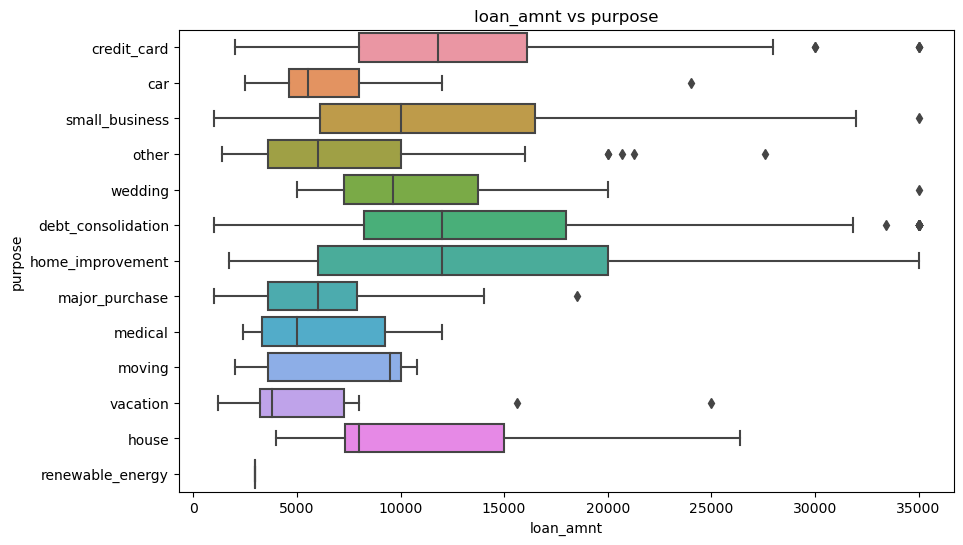

In [114]:
plot_bivariate('loan_amnt', 'purpose') # plot box plot of loan_amnt vs purpose

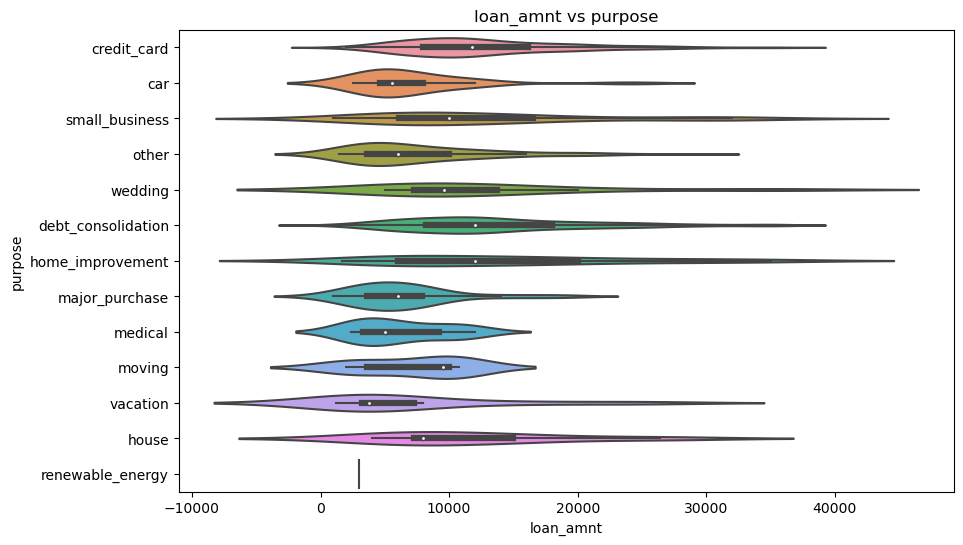

In [115]:
plot_bivariate('loan_amnt', 'purpose', plot=sns.violinplot) # plot violinplot

Insight: loan taken for home improvement, debt consolidation, and, wedding seem to be the most evenly distributed across the amount taken. For purposes like car, and major purchase, there is a high chance that the loan amount is between 2000 and 8000. Medical and moving seem to have no outliers such that they are likely to be between 3000 and 12000. 

### Grade vs total payment

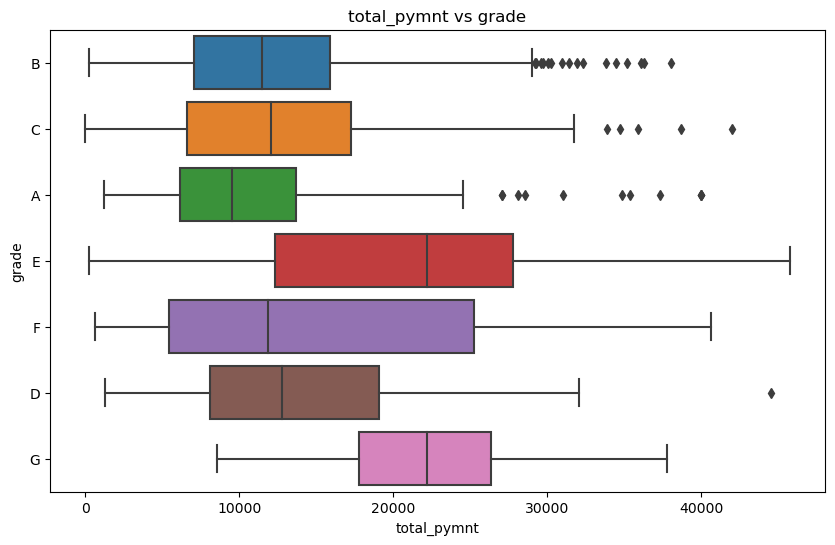

In [116]:
plot_bivariate('total_pymnt', 'grade') # plot box plot of total_pymnt vs grade

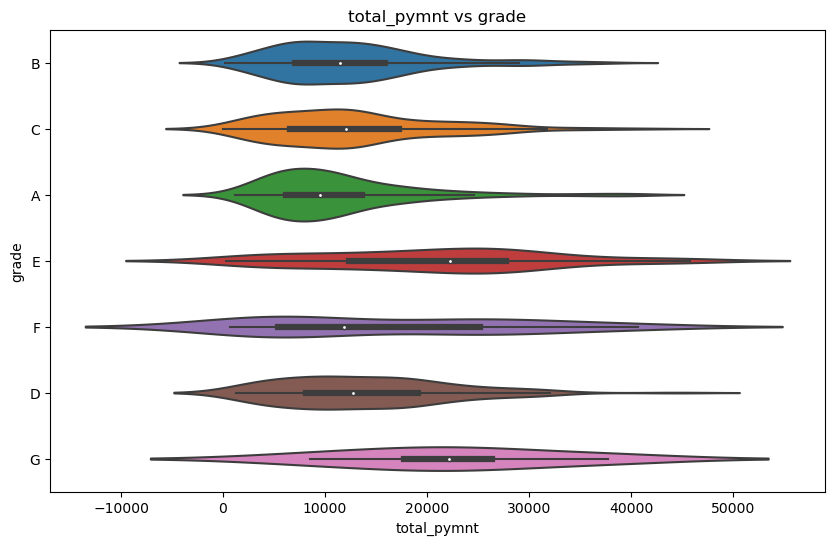

In [117]:
plot_bivariate('total_pymnt', 'grade', plot=sns.violinplot) # plot violinplot

Insight: Most of the data seems pretty evenly distributed throughout the total payment. Grade F and Grade G are the most evenly distributed throughout total payment. Grade A, grade, B, and, Grade C seem to be more likely to have a total payment between 2000 and 18000. Grade D is also evenly distributed but tends to have the value between 2000 and 22000 for total payment.

### Interest rate vs grade

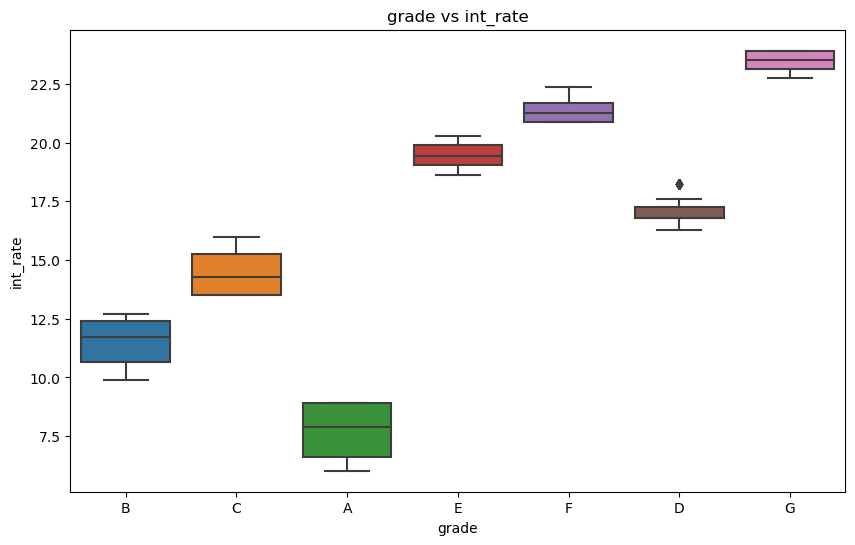

In [118]:
plot_bivariate('grade', 'int_rate') # plot box plot of int_rate vs grade

Insight: Interest rate tends to be increasing as grade goes from A to G

### Interest rate versus Annual Income (Continous vs Continous)

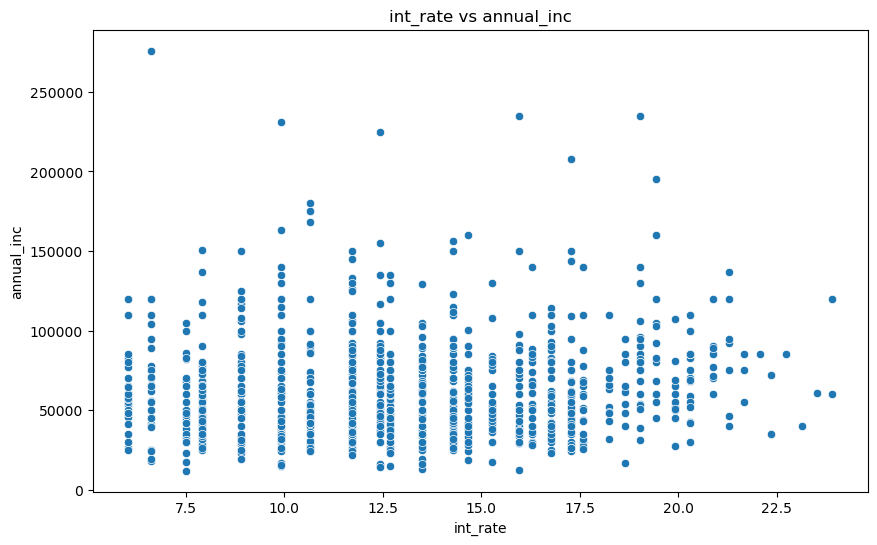

In [119]:
plot_bivariate('int_rate', 'annual_inc', plot=sns.scatterplot) # plot scatterplot

Insight: There seems to be no relation between the two attributes as the data seems to very scattered but the more of the points tends to be between 10000 and 100,000 for almost all interest rates.

### Loan amount vs funded amount (Continous vs continous)

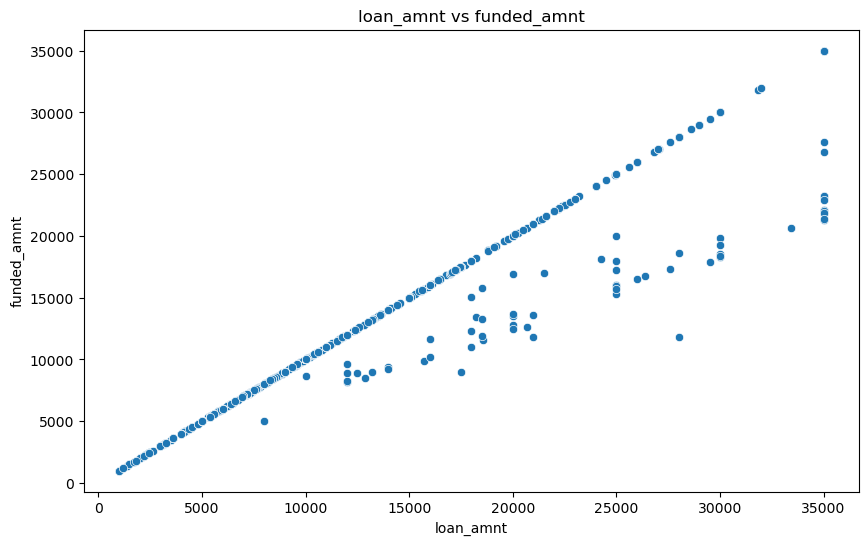

In [120]:
plot_bivariate('loan_amnt', 'funded_amnt', plot=sns.scatterplot) # scatterplot

Insight: There seems to be a linear positive relation among these two attributes.

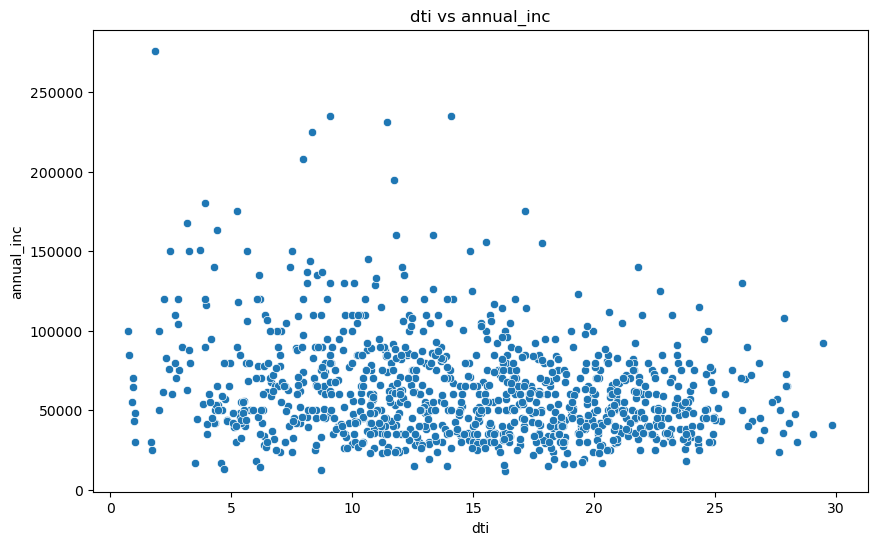

In [121]:
plot_bivariate('dti', 'annual_inc', plot=sns.scatterplot) # scatterplot

Insight: There seems to be no relation between the two attributes as the data seems to very scattered but the more of the points tends to be between 10000 and 100,000 for almost all dti.

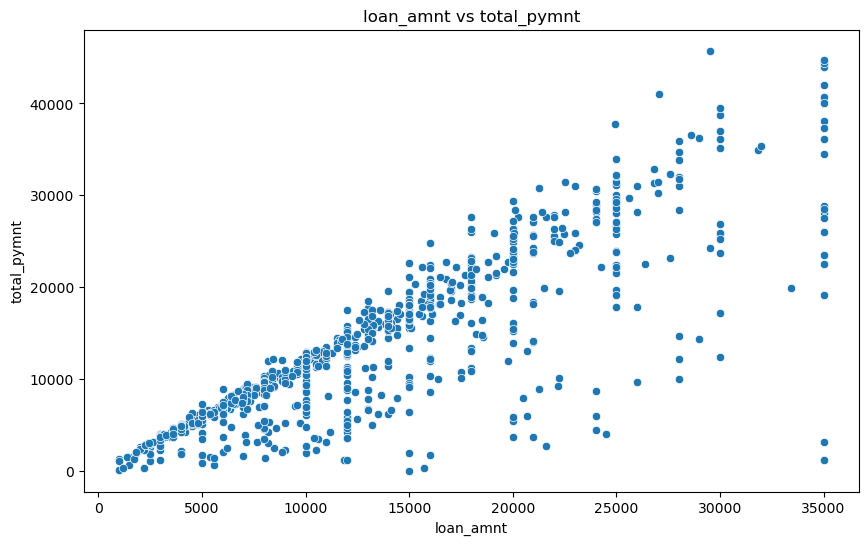

In [122]:
plot_bivariate('loan_amnt', 'total_pymnt', plot=sns.scatterplot) # scatterplot

Insight: There seems to be a positive relation between between both the attributes

### Multivariate (Correlation plot - Heatmap)

C:\Users\User\AppData\Local\Temp\ipykernel_1784\643623645.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='YlGnBu', annot=True)  # plot heatmap


<Axes: >

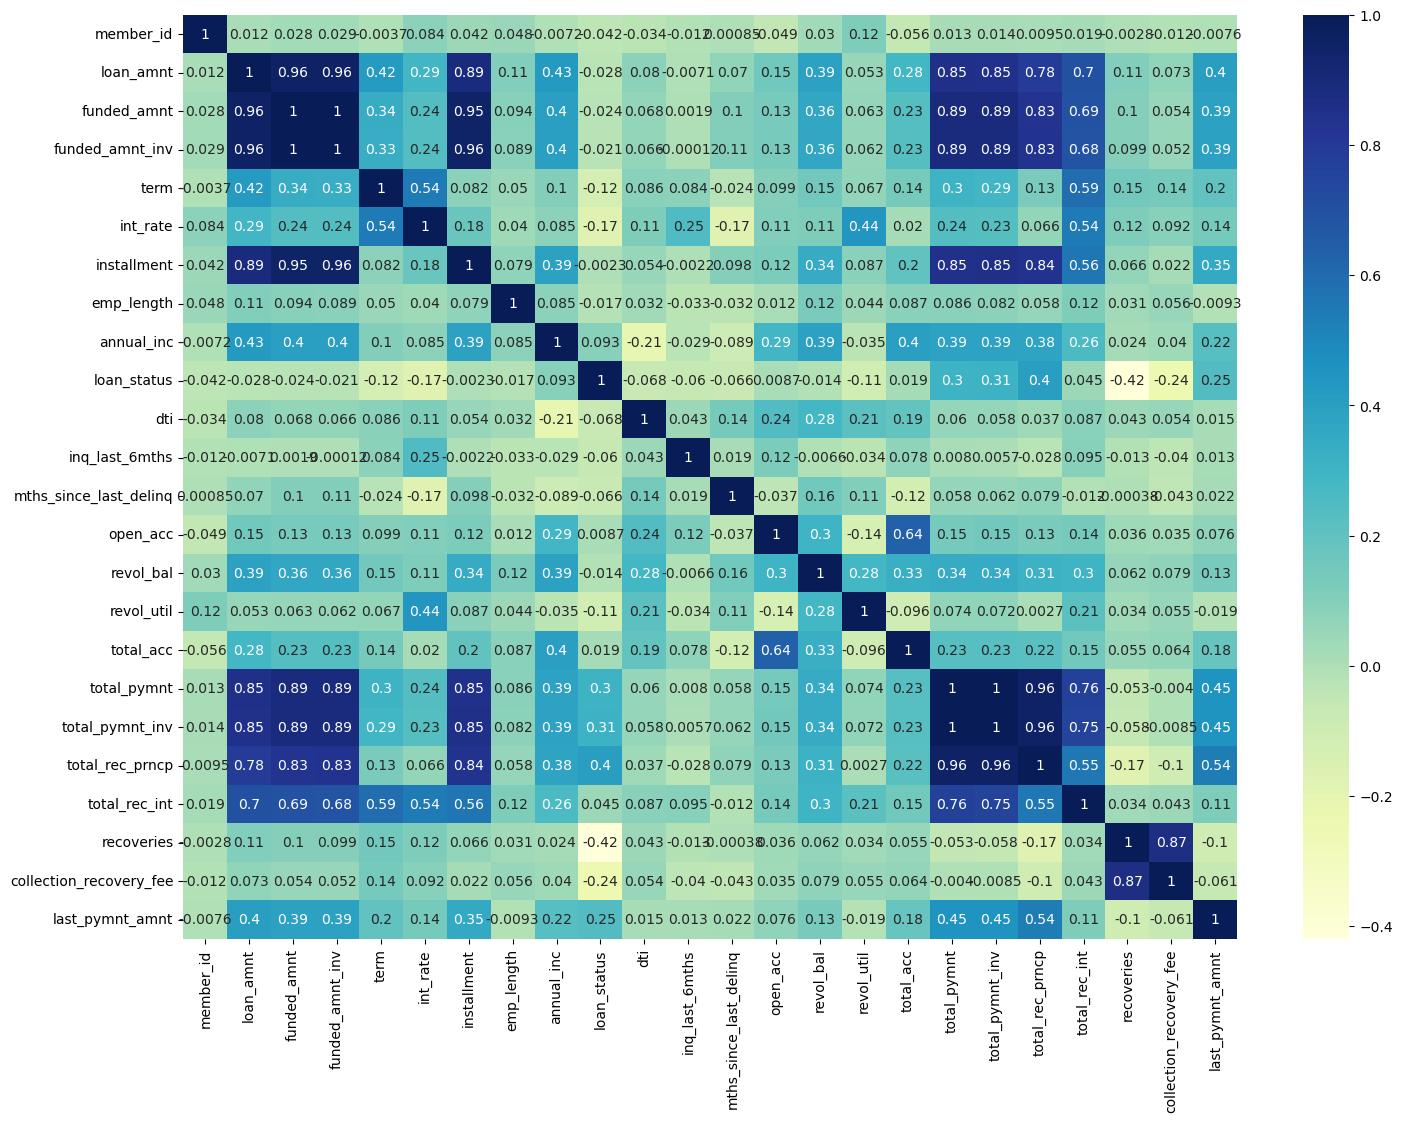

In [123]:
plt.figure(figsize=(17, 12))  # create a figure
sns.heatmap(data.corr(), cmap='YlGnBu', annot=True)  # plot heatmap

C:\Users\User\AppData\Local\Temp\ipykernel_1784\2024525691.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(data.corr(), 2), annot=True)  # plot heatmap


<Axes: >

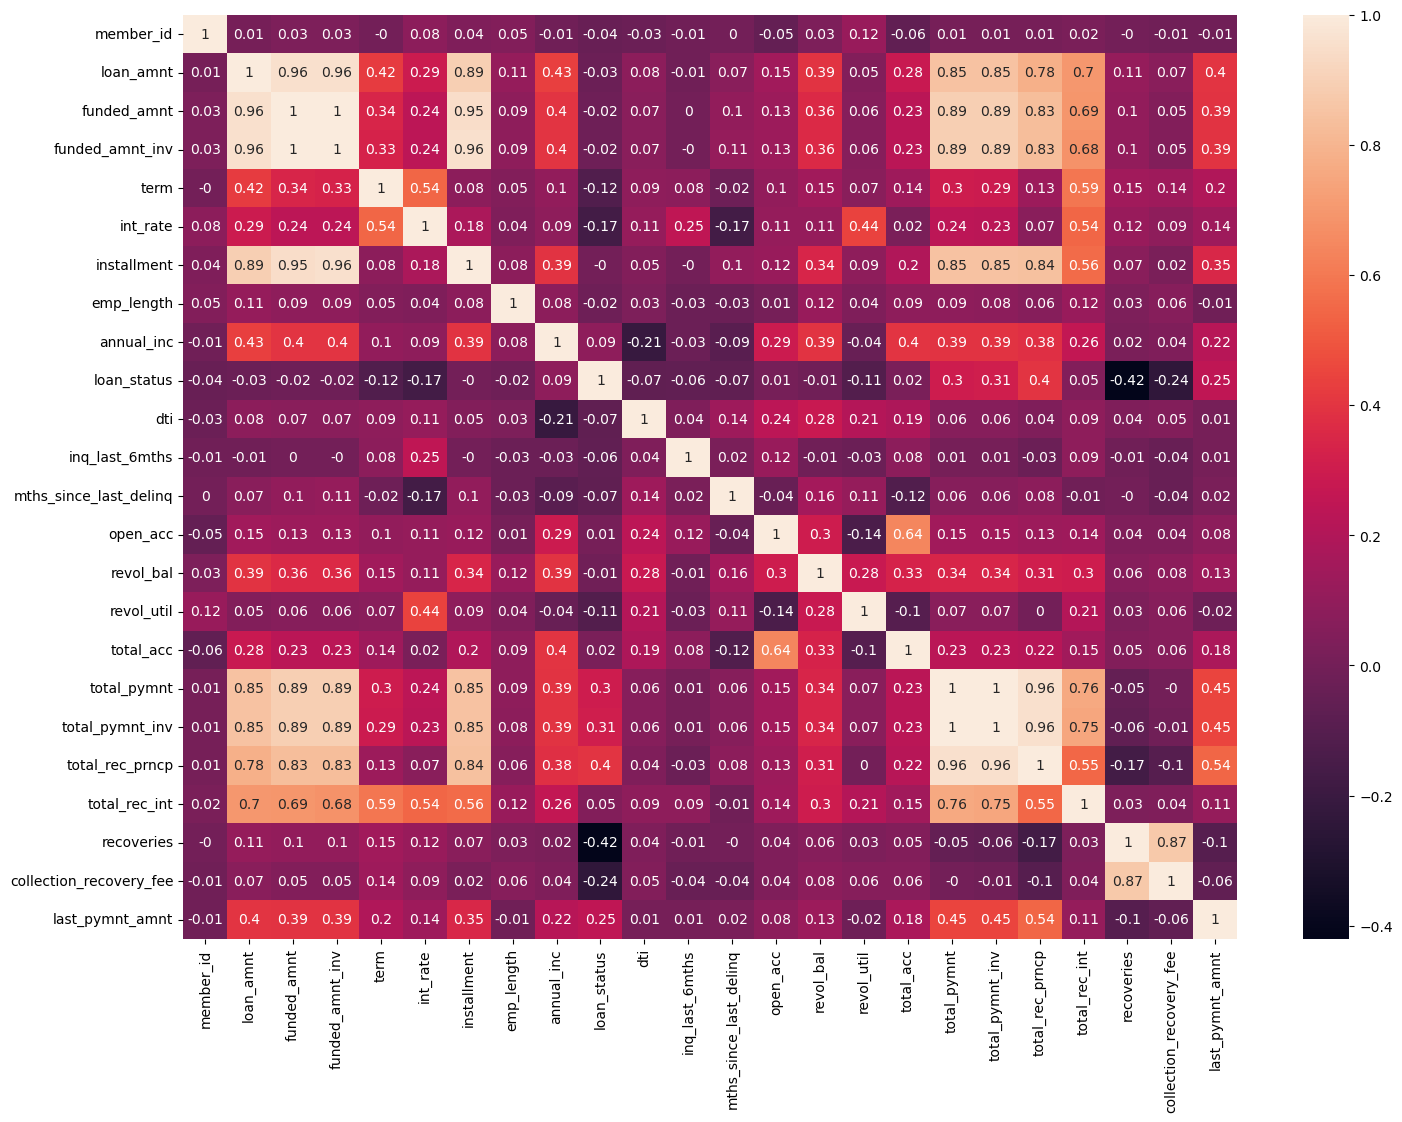

In [124]:
plt.figure(figsize=(17, 12))  # create a figure
sns.heatmap(round(data.corr(), 2), annot=True)  # plot heatmap

Insight: Obviously every attribute has a perfect relationship with itself. 
<br>
Strong relations:<br>
- Loan amount and funded amount <br>
- Loan amount and funded amount investment <br>
- Loan amount and installment <br>
- total payment investment and total recieved principle and total payment
- recoveries and collection recoveries fees